# INTRODUCTION

## RECOMENDATION ENGINE FOR CareerVillage.org 

## Problem 
CareerVillage.org is a nonprofit that crowdsources career advice for underserved youth. The platform uses a Q&A style similar to StackOverflow to provide students with answers to any question about any career.

Who provides this answers? 
The volunteers registered on the website that we called professionals.

Our objective in this kernel is to develop a method that recommend revelant questions to the professionals who are most likely to answer them.

## Proposed Solution 
This solution should provide a list of suggested questions to the professionals that frequents CareerVillage.org. For this to happen our recommendation engine tries to answer 3 questions:
 1. Has this question already an answer ?
 2. What's the main topic of this question ?
 3. Wich professionals should be able to answer this question the faster as possible ?

Based on the answers for those 3 questions the recommendation engine returns a list with the professionals that should recive the questions to answer.

# SET UP

## Imports

Importing the necessary libraries.

In [1]:
!pip install pyldavis &> /dev/null

from google.colab import drive
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models

import re
import spacy

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.ldamodel import LdaModel
from gensim.models import TfidfModel, Phrases
from gensim.corpora import Dictionary

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Global Settings 

Global variables and general settings for this notebook.

In [2]:
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/BASES DE DADOS/CAREERVILLAGE.ORG/data-science-for-good-careervillage.zip' &> /dev/null
path = r'/content/'

pd.set_option('display.max_columns', 100, 'display.width', 1024)
matplotlib.rcParams['axes.facecolor'] = '#E5E5E5'
PINK, PURPLE, BLUE = '#FF075E', '#B273FF', '#4D00B9'

seed = 14
np.random.seed(seed)

!python -m spacy download en_core_web_sm &> /dev/null
nlp = spacy.load('en_core_web_sm', disable = ['tagger', 'parser', 'attribute_ruler', 'ner', 'tok2vec'])

regex = re.compile(r'<[^>]+>')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading and Sorting Data


In [3]:
tags = pd.read_csv(path + 'tags.csv')
tag_users = pd.read_csv(path + 'tag_users.csv')
tag_questions = pd.read_csv(path + 'tag_questions.csv')

group_memberships = pd.read_csv(path + 'group_memberships.csv')
school_memberships = pd.read_csv(path + 'school_memberships.csv')
groups = pd.read_csv(path + 'groups.csv')

emails = pd.read_csv(path + 'emails.csv')
matches = pd.read_csv(path + 'matches.csv')

comments = pd.read_csv(path + 'comments.csv')
questions = pd.read_csv(path + 'questions.csv')
question_scores = pd.read_csv(path + 'question_scores.csv')
answers = pd.read_csv(path + 'answers.csv')
answer_scores = pd.read_csv(path + 'answer_scores.csv')

professionals = pd.read_csv(path + 'professionals.csv')
students = pd.read_csv(path + 'students.csv')

For this job we have multiple different datasets that we can merge based on their similatys and dependencies. Here is a visualization on how they behave that helped me to decide how to merge them.



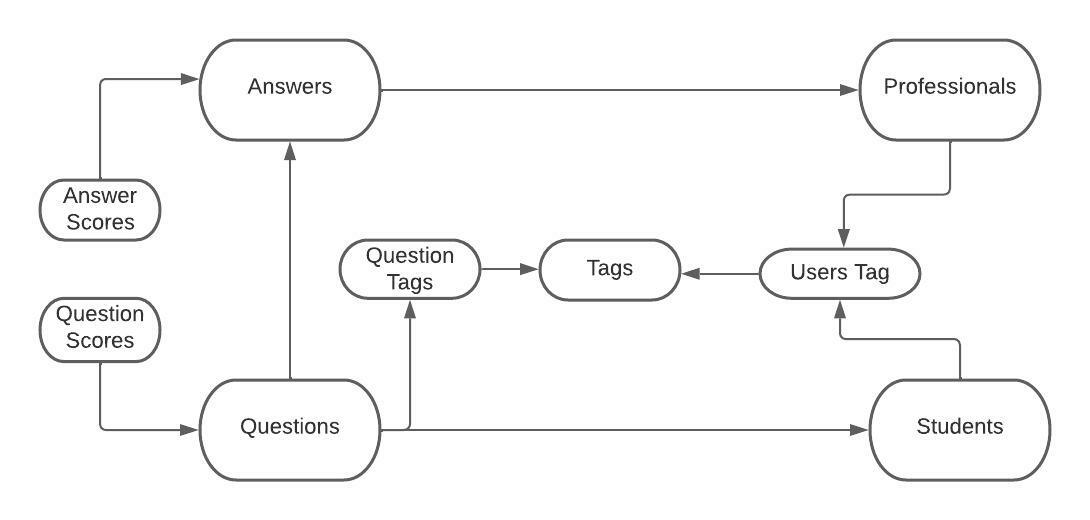

In [4]:
answer_scores.rename(columns = {'id' : 'answers_id'}, inplace = True)
answers = pd.merge(answers, answer_scores, on = 'answers_id')

tag_questions.rename(columns = {'tag_questions_tag_id' : 'tags_tag_id', 'tag_questions_question_id' : 'questions_id'}, inplace = True)
tag_questions = pd.merge(tag_questions, tags, on = 'tags_tag_id')

question_scores.rename(columns = {'id' : 'questions_id'}, inplace = True)
questions = pd.merge(questions, question_scores, on = 'questions_id')

tag_questions.drop('tags_tag_id', axis = 1, inplace = True)
tag_questions = tag_questions.groupby('questions_id').agg({'tags_tag_name' : ','.join}).reset_index()
questions = pd.merge(questions, tag_questions, on = 'questions_id')

tag_users.rename(columns = {'tag_users_tag_id' : 'tags_tag_id', 'tag_users_user_id' : 'user_id'}, inplace = True)
tag_users = pd.merge(tag_users, tags, on = 'tags_tag_id', how = 'left')
tag_users['tags_tag_name'] = tag_users['tags_tag_name'].apply(lambda x: x.replace('#',''))
tag_users.drop('tags_tag_id', axis = 1, inplace = True)

students.rename(columns = {'students_id' : 'user_id'}, inplace = True)
professionals.rename(columns = {'professionals_id' : 'user_id'}, inplace = True)

tag_users = tag_users.groupby('user_id').agg({'tags_tag_name' : ','.join}).reset_index()

professionals = professionals.merge(tag_users, on = 'user_id', how = 'left')
students = students.merge(tag_users, on = 'user_id', how = 'left')

## Functions

Functions that will be used in this notebook.

In [5]:
def get_nan(dataframe):

  ''' This function takes a Pandas dataframe and then return a new Pandas dataframe with 
  the leaking values for each feature in the entry datframe
  '''

  missing = pd.DataFrame()
  for i in dataframe.columns:
    missing_values = dataframe[i].isna().sum()
    not_missing_values = len(dataframe) - dataframe[i].isna().sum()
    temp = pd.DataFrame({'feature' : i,
                         'total_values' : len(dataframe),
                         'missing_values' : missing_values,
                         'not_missing' : not_missing_values}, index = [0])
    missing = pd.concat([missing, temp], axis = 0)
  missing.reset_index(drop = True, inplace = True)

  return missing


def lemmatizer(doc):

  '''This function receive a nlp.doc(spacy object) and returns the lemmas without 
  stopwords and punctuations
  '''

  cleaned_text = []
  for token in doc:
    valid = not token.is_stop and token.is_alpha
    if valid:
      cleaned_text.append(token.lemma_)
  return ' '.join(cleaned_text)

# EDA

## Users Data

There are 28152 professionals and 30971 students registered in CareerVillage.org.

Professionals trends to higly use *Location*, *Industry*, *Headline* and *Tags*. Those features will be used in our recomendation engine.

Students trends to use *Location* but rarely uses *Tags*.
Due this leak of data, we'll not use students tags in our model.

Near about 60% students never posted a question.

The same is valid for professionals and asnwers. Aproximattely 64% professionals registered in the site never posted an answer.

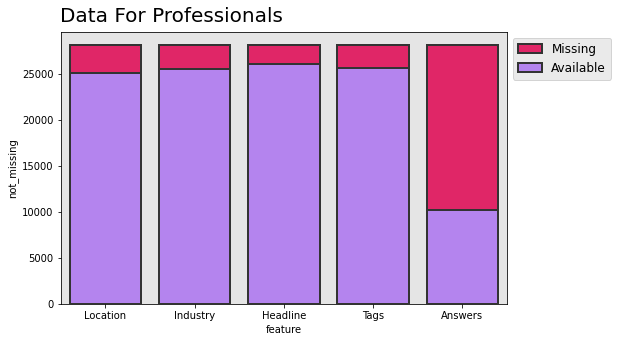

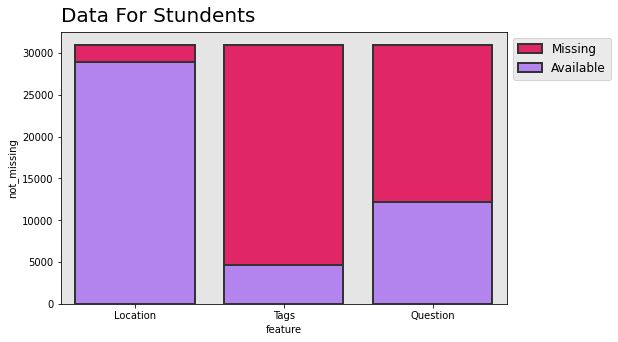

In [6]:
# Getting the data for professionals

temp = get_nan(professionals)
prof_who_ans = len(answers.groupby('answers_author_id').sum())
prof_who_not_ans = len(professionals) - prof_who_ans
temp_dict = {'feature' : 'answers',
             'total_values' : professionals.shape[0],
             'missing_values' : prof_who_not_ans,
             'not_missing' : prof_who_ans}
temp = pd.concat([temp, pd.DataFrame(temp_dict, index = [6])], axis = 0)
temp.drop([0,4], axis = 0, inplace = True)
plt.figure(figsize = (8,5))
sns.barplot(x = 'feature',
            y = 'total_values',
            color = PINK,
            linewidth = 2,
            edgecolor=".2",
            label =  'Missing',
            data = temp)
sns.barplot(x = 'feature',
            y = 'not_missing',
            color = PURPLE,
            label = 'Available',
            data = temp,
            linewidth = 2,
            edgecolor=".2")
plt.suptitle(t = 'Data For Professionals', fontsize = 20, x = 0.318, y = 0.95)
plt.xticks([0, 1, 2, 3, 4], ['Location', 'Industry', 'Headline', 'Tags', 'Answers'])
plt.legend(bbox_to_anchor=(1, 1), fontsize=12)
plt.show()


# Getting the data for students

temp = get_nan(students)
stud_who_ask = len(questions.groupby('questions_author_id').sum())
stud_who_dont_ask = len(students) - stud_who_ask
temp_dict = {'feature' : 'questions',
             'total_values' : students.shape[0],
             'missing_values' : stud_who_dont_ask,
             'not_missing' : stud_who_ask}
temp = pd.concat([temp, pd.DataFrame(temp_dict, index = [4])], axis = 0)
temp.drop([0,2], axis = 0, inplace = True)
plt.figure(figsize = (8,5))
sns.barplot(x = 'feature',
            y = 'total_values',
            color = PINK,
            linewidth = 2,
            edgecolor=".2",
            label =  'Missing',
            data = temp)
sns.barplot(x = 'feature',
            y = 'not_missing',
            color = PURPLE,
            label = 'Available',
            data = temp,
            linewidth = 2,
            edgecolor=".2")
plt.suptitle(t = 'Data For Stundents', fontsize = 20, x = 0.295, y = 0.95)
plt.xticks([0, 1, 2], ['Location', 'Tags', 'Question'])
plt.legend(bbox_to_anchor=(1, 1), fontsize=12)
plt.show()

## Users Location

Both students and professionals higly uses *Location*, the charts below shows that most of the students are from US and India. The professionals are mostly from US.

*Location* is an important feature seen that a lot of career can be location dependent.

Professionals may be more apt to help students with career doubts who come from the same location as them, as they know better how behave their profession in that place.

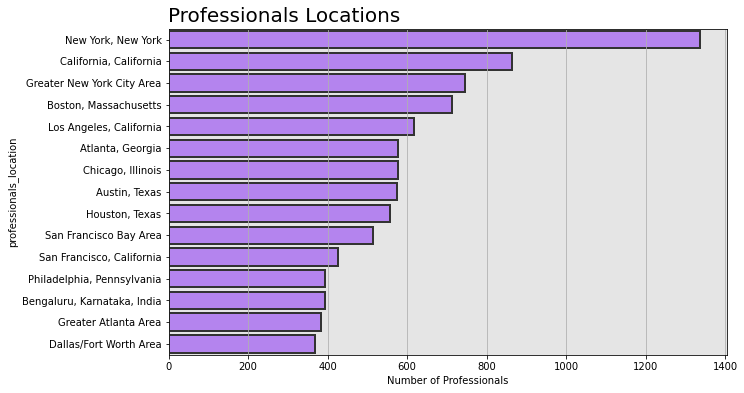

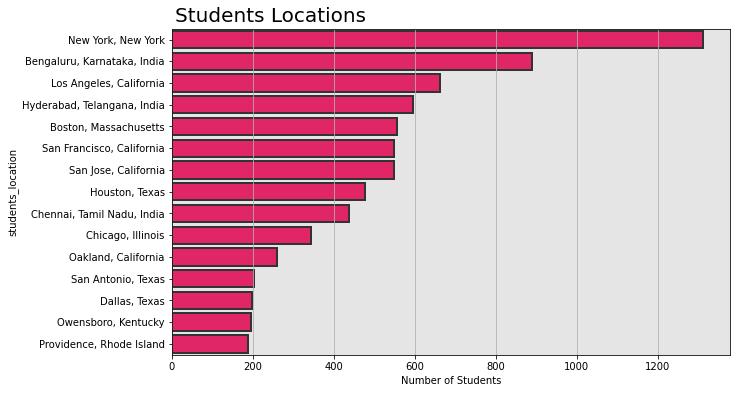

In [7]:
temp = professionals.groupby('professionals_location').size().sort_values(ascending = False).reset_index().head(15)
plt.figure(figsize = (10,6))
sns.barplot(x = 0,
            y = 'professionals_location',
            data = temp,
            color = PURPLE,
            linewidth = 2,
            edgecolor=".2")
plt.suptitle('Professionals Locations', x = 0.286, y = 0.93, fontsize = 20)
plt.xlabel('Number of Professionals')
plt.grid(axis = 'x')
plt.show()

temp = students.groupby('students_location').size().sort_values(ascending = False).reset_index().head(15)
plt.figure(figsize = (10,6))
sns.barplot(x = 0,
            y = 'students_location',
            data = temp,
            color = PINK,
            linewidth = 2,
            edgecolor=".2")
plt.suptitle('Students Locations', x = 0.262, y = 0.93, fontsize = 20)
plt.xlabel('Number of Students')
plt.grid(axis = 'x')
plt.show()

## Professional Industries

From the 28152 professionals  registered in the site only 2576 dont specifies their industries. There are in total 2471 different values for industries in our data. The chart below shows the 15 most populated industries.

If we're able to find the main topics of a question, it would be easy to send this question to a professional that can answer it, based on its industry.

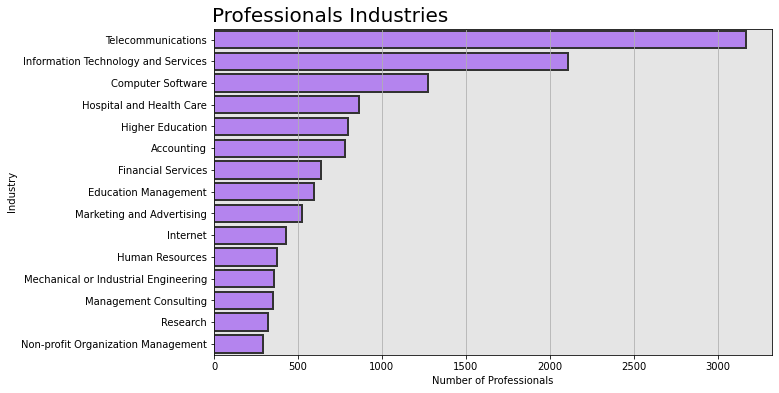

In [8]:
temp = professionals.groupby('professionals_industry').size().sort_values(ascending = False).reset_index().head(15)
plt.figure(figsize = (10,6))
sns.barplot(x = 0,
            y = 'professionals_industry',
            data = temp,
            color = PURPLE,
            linewidth = 2,
            edgecolor=".2")
plt.suptitle('Professionals Industries', x = 0.286, y = 0.93, fontsize = 20)
plt.xlabel('Number of Professionals')
plt.ylabel('Industry')
plt.grid(axis = 'x')
plt.show()

## Growth of Users

Here we can see the growth of registered users over the years, and the amount of new users registered for each year.

Despite the growing number of professional registrations on CareerVillage.org, only near 36% of the professionals trends to be active in the site.

This acitivity will be monitorated for use in the recomendation engine.

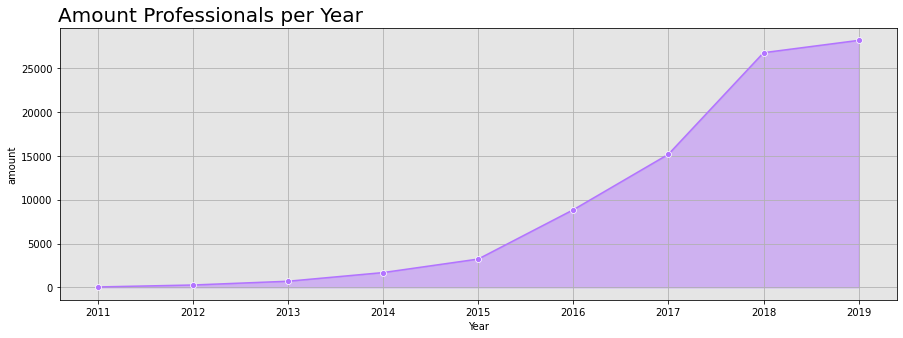

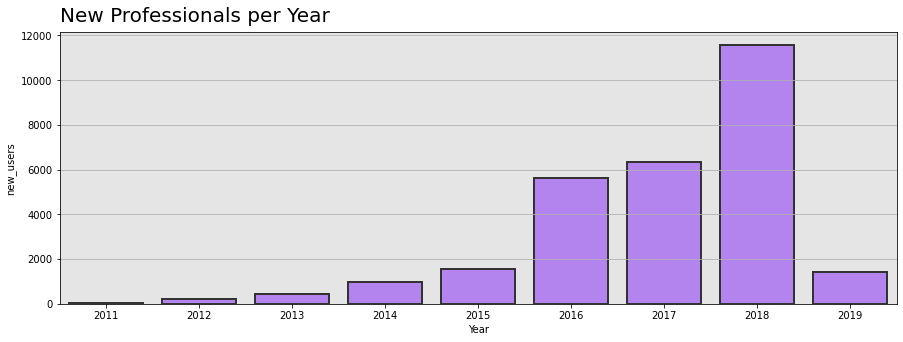

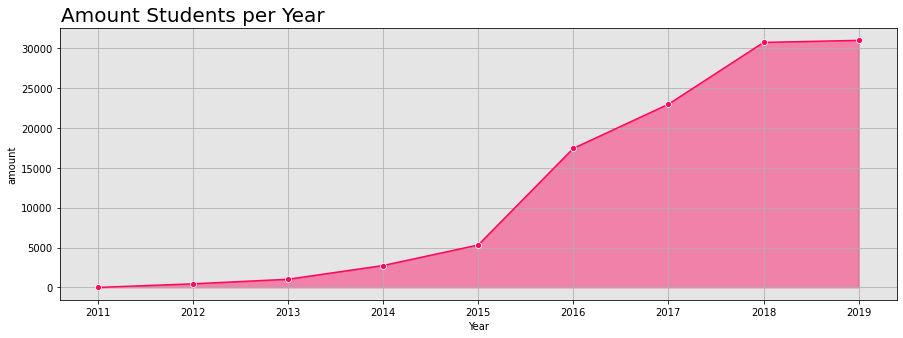

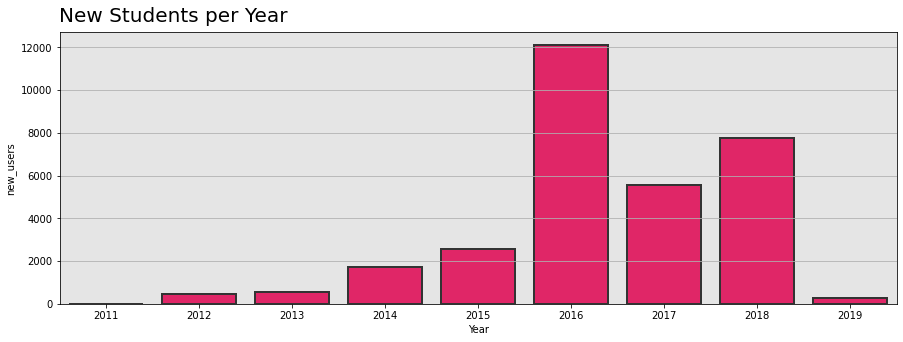

In [9]:
# Setting datetime like features to datetime objetcs

professionals['year_joined'] = pd.to_datetime(professionals['professionals_date_joined']).dt.year
students['year_joined'] = pd.to_datetime(students['students_date_joined']).dt.year

# Ploting data for professionals

plt.figure(figsize = (15,5))
temp = professionals.groupby('year_joined').size().reset_index()
temp.rename(columns = {0 : 'new_users'}, inplace = True)
temp['amount'] = temp['new_users'].cumsum()
sns.lineplot(x = 'year_joined',
             y = 'amount',
             color = PURPLE,
             marker = 'o',
             data = temp)
plt.fill_between(temp['year_joined'], temp['amount'], color = PURPLE, alpha = 0.45)
plt.suptitle('Amount Professionals per Year', x = 0.265, y = 0.94, fontsize = 20)
plt.xlabel('Year')
plt.grid()
plt.show()

plt.figure(figsize = (15,5))
sns.barplot(x = 'year_joined',
            y = 'new_users',
            color = PURPLE,
            linewidth = 2,
            edgecolor=".2",
            data = temp)
plt.suptitle('New Professionals per Year', fontsize = 20, x = 0.25, y = 0.95)
plt.grid(axis = 'y')
plt.xlabel('Year')
plt.show()

# Ploting data for students

plt.figure(figsize = (15,5))
temp = students.groupby('year_joined').size().reset_index()
temp.rename(columns = {0 : 'new_users'}, inplace = True)
temp['amount'] = temp['new_users'].cumsum()
sns.lineplot(x = 'year_joined',
             y = 'amount',
             color = PINK,
             marker = 'o',
             data = temp)
plt.fill_between(temp['year_joined'], temp['amount'], color = PINK, alpha = 0.45)
plt.suptitle('Amount Students per Year', x = 0.248, y = 0.94, fontsize = 20)
plt.xlabel('Year')
plt.grid()
plt.show()

plt.figure(figsize = (15,5))
sns.barplot(x = 'year_joined',
            y = 'new_users',
            color = PINK,
            linewidth = 2,
            edgecolor=".2",
            data = temp)
plt.suptitle('New Students per Year', fontsize = 20, x = 0.23, y = 0.95)
plt.grid(axis = 'y')
plt.xlabel('Year')
plt.show()


## Users Activity 

The plot below shows the growth of the mean response time per year. 
As the website grewed the average response time decreased.


Our goal is to get the professionals who can answers the new questions the faster as possible. Thats why the response time will be an important feature in the construction of our recommendation engine.

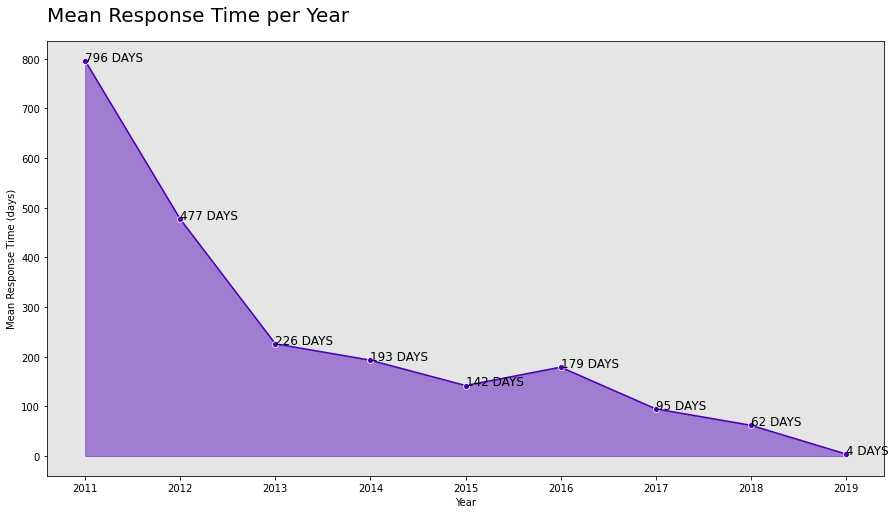

In [10]:
# Setting the datetime like features to datetime objetcs

questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'], infer_datetime_format = True)
answers['answers_date_added'] = pd.to_datetime(answers['answers_date_added'], infer_datetime_format = True)

# Merging questions and its answers

answers.rename(columns = {'answers_question_id' : 'questions_id'}, inplace = True)
temp = answers.merge(questions , on = 'questions_id', how = 'left')
temp.drop_duplicates('answers_id', inplace = True)
temp.reset_index(inplace = True)
temp.drop(['index', 'answers_body', 'score_x', 'questions_author_id', 'questions_title', 'questions_body', 'score_y', 'tags_tag_name'], axis= 1, inplace = True)

temp['response_time'] = (temp['answers_date_added'].sub(temp['questions_date_added']))
temp.rename(columns = {'answers_author_id' : 'user_id'}, inplace = True)

# Mean response time for each professional

mean_response_time_pro = temp.groupby('user_id')['response_time'].mean().reset_index()
professionals = professionals.merge(mean_response_time_pro, on = 'user_id', how = 'left')

# Mean response time per year

temp['year'] = pd.to_datetime(temp['questions_date_added']).dt.year
mean_response_time_year = temp.groupby('year')['response_time'].mean().reset_index()
mean_response_time_year['response_time'] = mean_response_time_year['response_time'].dt.days

# Plotting vizualisations

plt.figure(figsize = (15,8))
sns.lineplot(x = 'year',
             y = 'response_time',
             color = BLUE,
             marker = 'o',
             data = mean_response_time_year)
plt.fill_between(mean_response_time_year['year'], mean_response_time_year['response_time'], color = BLUE, alpha = 0.45)
plt.suptitle('Mean Response Time per Year', x = 0.265, y = 0.94, fontsize = 20)
plt.xlabel('Year')
plt.ylabel('Mean Response Time (days)')

for a,b in zip(mean_response_time_year['year'], mean_response_time_year['response_time']):
    plt.text(a, b, str(b) + ' DAYS', fontsize = 12)
plt.show()

##WordClouds


A WordCloud is a graph that shows n most frequent words in a document. Inside the wordcloud the words will be counted and the most frequent words looks bigger then the less frequents words. 

When looking at the wordcloud plots, thats clear that the question tags are more generalized than professional industries, which tend to be more specific as to the professional's area of ​​expertise.

Therefore the question tags would not be a good indicator of questions main topics.

Text(0.5, 1.0, 'Professionals Industries WordCloud')

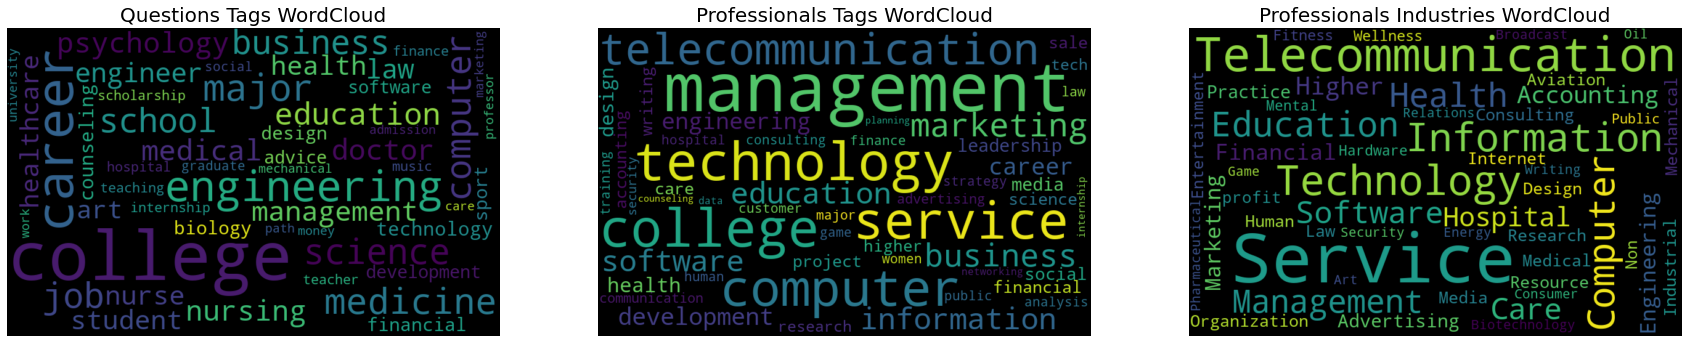

In [11]:
# Questions WordClouds

wordcloud_ = WordCloud(width = 800, height = 500,
                           max_font_size = 110, collocations = False, max_words = 50)

temp = ' '.join([palavra for palavra in questions['tags_tag_name']])
wordcloud_.generate(temp)

plt.figure(figsize=(30,20))

plt.subplot(1,3,1)
plt.imshow(wordcloud_, interpolation = 'bilinear')
plt.axis('off')
plt.title('Questions Tags WordCloud', fontsize = 20)

# Professionals tags WordCloud

temp = ' '.join([palavra for palavra in professionals['tags_tag_name'].dropna()])
wordcloud_.generate(temp)

plt.subplot(1,3,2)
plt.imshow(wordcloud_, interpolation = 'bilinear')
plt.axis('off')
plt.title('Professionals Tags WordCloud', fontsize = 20)


temp = ' '.join([palavra for palavra in professionals['professionals_industry'].dropna()])
wordcloud_.generate(temp)

plt.subplot(1,3,3)
plt.imshow(wordcloud_, interpolation = 'bilinear')
plt.axis('off')
plt.title('Professionals Industries WordCloud', fontsize = 20)

# NLP


For this work we'll use 2 techniques to deal with the texts data.
1. Paragraph Vector, that we'll use to get the word embbedings.
2. Latent Dirichlet Allocation, that we'll use to get main topics for each question. 

But before this the textual data must be cleaned.

## Cleaning Data

Before passing our data into the tecniques, we must clean it. In this cleaning process we'll:
1. cast every word to lower case.
2. remove HTML tags.
3. remove stopwords and punctuation.
- Stopwords are words that doesnt aggregate with sematic value in the sentences they belong. This words just bring computational complexity to our model, thats why we remove them. 
4. apply lemmatization to every word left.
- Lemmatizaion is a process that reduces words to their lemma(a sort of root form), based on its intended meaning.

In [12]:
# Filling the NaN values with 'unknow'

except_ = ['response_time']
for i in professionals.columns:
  if i not in except_:
    professionals[i].fillna('unknow', inplace = True)

# Removing the HTML tags from the answers and questions and setting all texts to lower case

questions['questions_body'] = questions['questions_body'].apply(lambda x: re.sub(regex , '', str(x).lower()))
questions['questions_title'] = questions['questions_title'].apply(lambda x: re.sub(regex , '', str(x).lower()))

professionals['professionals_industry'] = professionals['professionals_industry'].apply(lambda x: x.lower())

#### Removing stopwords, punctuation and lemmatizing words
# -> OBS: Im using list comprehension because among all methods i've tried it seems to be the faster way to clean our texts) <-

questions['cleaned_question_tags'] = [lemmatizer(doc) for doc in nlp.pipe(questions['tags_tag_name'],
                                         batch_size = 5000,
                                         n_process = 1)]
questions['cleaned_title'] = [lemmatizer(doc) for doc in nlp.pipe(questions['questions_title'],
                                         batch_size = 5000,
                                         n_process = 1)]
questions['cleaned_body'] = [lemmatizer(doc) for doc in nlp.pipe(questions['questions_body'],
                                         batch_size = 5000,
                                         n_process = 1)]

questions['whole_question'] = questions['questions_title'] + ' - ' + questions['questions_body']
questions['whole_question_cleaned'] = questions['cleaned_title'] + ' ' + questions['cleaned_body']

Here is a view on how look the documents before and after beeing cleaned.

In [13]:
pd.set_option("display.max_colwidth", -1)

# Creating visualization to do comparison on the original texts and the clean ones
## For the questions

temp = {'title' : [questions['questions_title'].iloc[2],
                   questions['cleaned_title'].iloc[2]],
        'body' : [questions['questions_body'].iloc[2],
                  questions['cleaned_body'].iloc[2]],
        'tags' : [questions['tags_tag_name'].iloc[2],
                  questions['cleaned_question_tags'].iloc[2]]}

temp = pd.DataFrame(temp, index = ['Original', 'Cleaned'])
temp = temp.T
display(temp)

,Original,Cleaned
title,will going abroad for your first job increase your chances for jobs back home?,going abroad job increase chances jobs home
body,"i'm planning on going abroad for my first job. it will be a teaching job and i don't have any serious career ideas. i don't know what job i would be working if i stay home instead so i'm assuming staying or leaving won't makeba huge difference in what i care about, unless i find something before my first job. i can think of ways that going abroad can be seen as good and bad. i do not know which side respectable employers willl side with. #working-abroad #employment- #overseas",planning going abroad job teaching job career ideas know job working stay home instead assuming staying leaving wo makeba huge difference care find job think ways going abroad seen good bad know respectable employers willl working abroad overseas
tags,"overseas,working-abroad",overseas working abroad


Before we pass to the algorithms, our data will be splited into train and test, for futher model evaluation.

In [14]:
# Sorting the data by date

questions.sort_values('questions_date_added', ascending = True, inplace = True)
questions.reset_index(drop = True, inplace = True)

questions_final = questions.copy()

# Spliting into train and test datasets

que_train = questions.iloc[:-5]
que_test = questions.iloc[-5:]

## Paragraph Vector (Doc2Vec)

Paragraph Vector is a technique used for unsupervised training of word embbedings(dense vectors). Is a sort of development from Word2Vec, from the same author Tomas Mikolov,  the difference is that Paragraph Vector uses not only words for his embbeding but also whole sentences, paragraphs or documents. This allows the Paragraph Vector to better incorporate in his embbedings the context in which the words was inserted. In the original paper this technique shown to have embbedings with a large better semantic comprehension.

For this job we'll use the Paragraph Vector implementation at Gensim library thats named Doc2Vec.

### Training

From our 23281 questions the model built a vocabulary with 7345 unique words, 6239 words were droped due the paramether *min_count = 2*.

The training taked about 6 min to run entirely.

In [15]:
# gensim.Doc2Vec require a list of tagged documents as input

corpus = [TaggedDocument(words = text, tags = [i]) for i, text in enumerate(que_train['whole_question_cleaned'].str.split())]

# Instatiate the model

model_d2v = Doc2Vec(vector_size = 300, # => the size of the output vectors
                  alpha = 0.025, # => the initial learning rate
                  min_alpha = 0.001, # =>  learning rate will linearly drop to min_alpha as training progresses
                  window = 5, # => the maximum distance between the current and predicted word within a sentence
                  min_count = 2, # => words with less than 2 ocurrences will not be used on training 
                  dm = 0, # => using PV-DBOW
                  hs = 1, # => using hierarchical softmax for training
                  workers = 6, # => using more threads for faster training 
                  epochs = 40, # => number of iterations over the corpus
                  dm_mean = 1) # => using average for vectors combination, we've tested concatenation and sum but average seens to be the better one

# Building vocabulary and training the model

model_d2v.build_vocab(corpus)

model_d2v.train(corpus, total_examples = model_d2v.corpus_count, epochs = model_d2v.epochs)

### Sanity Check

Evaluate embbedings is a hard task, a way to do this is sanity check.
For this, we infer vectors for the training data, pretending they are some new unseen data. Then we get the most similar documents for those infered vectors. A consistent model should provide the documents themselves as the most similars for they infered vectors.

Basically, greater than 97% of the inferred documents are found to be most similar to itself and about 3% of the time it is mistakenly most similar to another document. The model is behaving in a usefully consistent manner, though not a real ‘accuracy’ value.

In [16]:
most_similars = []

for doc_id in range(len(corpus)):
    inferred_vector = model_d2v.infer_vector(corpus[doc_id].words)
    similar = model_d2v.docvecs.most_similar([inferred_vector], topn = 1)[0][0]
    most_similars.append(similar)

index_ = list(range(0, len(most_similars)))

comparison = [[i, j] for i, j in zip(index_, most_similars)]

# Sanity Check function

def sanity_check(to_check):
  check = 0
  for i, j in to_check:
    if i == j:
      check += 1

  temp = {'similars to itfelf' : check,
          'mistankily similar to another document' : len(most_similars) - check}

  temp = pd.DataFrame(temp, index = [0])

  return temp


sanity_check(comparison)

,similars to itfelf,mistankily similar to another document
0,23214,66


### Test Data


Here we infered vectors for the test documents then we taked the 2 most similars documents according to our model. Not all the questions have similars ones, despite that the model seems to have correctly incorporated the meaning of the questions, as we can see at the fourth and fifth examples.

In [17]:
test_list = [text for text in que_test['whole_question_cleaned'].str.split()]
test_list_show = [text for text in questions['whole_question_cleaned'].iloc[-5:]]
test_ = [[i, j] for i,j in zip(test_list, test_list_show)]

similaritys = []
similars = []
second_most_similars = []
second_most_similaritys = []

for i,j in test_:
  inferred_vector = model_d2v.infer_vector(i)
  similar = model_d2v.docvecs.most_similar([inferred_vector], topn=1)[0][0]
  similarity = model_d2v.docvecs.most_similar([inferred_vector], topn=1)[0][1]
  second_most_similar = model_d2v.docvecs.most_similar([inferred_vector], topn=2)[1][0]
  second_most_similarity = model_d2v.docvecs.most_similar([inferred_vector], topn=2)[1][1]

  similars.append(similar)
  similaritys.append(similarity)
  second_most_similars.append(second_most_similar)
  second_most_similaritys.append(second_most_similarity)

temp_dict = {'test question' : test_list_show,
             'most similar question' : [text for text in questions['whole_question'].iloc[similars]],
             'cosine similarity - 1' : similaritys,
             'second most similar question' : [text for text in questions['whole_question'].iloc[second_most_similars]],
             'cosine similarity - 2' : second_most_similaritys}

temp = pd.DataFrame(temp_dict)

display(temp)

,test question,most similar question,cosine similarity - 1,second most similar question,cosine similarity - 2
0,like material handling operation distribution operation like material handling operation distribution operations job,how do you see material handling distribution operations in the next 10 years ? - what do you see yourself in the next 10 years ? #education a,0.703546,training in material handling distribution operations - what type of training did you have to receive prior to working in such a field of this type of work #training,0.615817
1,recommend speak career want recommend speak career want education,how can i improve my communication in english - i want to speak in english fluently #english,0.557793,how to speak in french language? - hi i am nandhini i want to speak in french but i do know how to speak in french language. #professor #student #french,0.547939
2,kindsof work samples prolfolio kinds work samples portfolio job,what kind of writing samples should i give when asked? - most jobs in public relations ask for writing samples before the interview process. what kind of writing should i submit? are there things the recruiters prefer to see?\r\n\r\n#public-relations #writing #writing-samples,0.560214,where do you get internships as a creative writing major? - #majors #major,0.509749
3,typical day like network cable installation technology networking business management,what do you like least about network cable installation? - computers #computer-science #information-technology #computer-engineering,0.767986,what is a cable installer's workday schedule like ? - does a network cable installer work fixed regular hours or do they work by set appointments at a time ?\r\n\r\n#cableinstaller,0.601455
4,graphics gcse interior designer interior design,what is the hardest part of being an interior designer? - i'd like to be an interior designer? #interior-design,0.674308,"do i have to brush up my drawing skills to become an architecture? - i want to become an architect but my drawing skills are not up to the mark,what do i do? #design #architect #interior #drawing #drawing-skills",0.623301


## Latent Dirichlet Allocation


On the porpose to get the main topics for each question, we'll implement the Latent Dirichlet Allocation. Wich is a bayesian algorithm that gives us the document probabilities for belonging to topics based on words frequency. The basic idea is that documents are represented as random mixtures over latent topics, where each topic is characterized by a distribution over words.One more time a gensim implementation will be used.

### Training 

before get the topics we must:
+ Separate the sentences into tokens, possibly words or pairs of words(if the pair makes more sense than the words individually, for instance *data science*).
+ Create a dictionary, where the words will be filtered.
+ Map the words with ids and covert to -> (word_id, word_frequency) format.
+ Get a tf-idf vector for the sentences.
+ Train the LDA model to get the main topics.

In [18]:
# Words that appears most commonly together probrably make more sense together than separated

train = list(questions['whole_question_cleaned'].str.split())

bigram = Phrases(train, min_count = 30)
texts = [bigram[question] for question in train]

# Creating a Dictionary, words that appears in less than 20 documents and words that appears in more than 60% documents will not be used in the model.

id2word = Dictionary(texts)
id2word.filter_extremes(no_below = 20, no_above = 0.6, keep_n = 8000)

# Mapping each unique word to its frequency in the document

bow = []
for sentence in texts:
  new = id2word.doc2bow(sentence) # => convert to format (word_id, word_frequency)
  bow.append(new)

# Converting the bag-of-words to tf-idf vectors

tfidf = TfidfModel(bow)
corpus = tfidf[bow]

# Training the model

LDAmodel = LdaModel(corpus = corpus,
                 id2word = id2word,
                 num_topics = 24, # => number of topics manually selected
                 random_state = 0, # =>
                 update_every = 0,
                 chunksize = 1000,
                 passes = 25, # => epochs
                 alpha = 'auto',
                 eta = 'auto')

# Ploting a visualization for the topics distribuition in space

pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim_models.prepare(LDAmodel, corpus, id2word, mds = 'mmds', R = 30)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.032844 -0.003448  1       1        28.935002
22     0.039998 -0.127337  2       1        6.922660 
23    -0.023602 -0.167097  3       1        6.523746 
21     0.018438  0.091582  4       1        5.374108 
13    -0.149013  0.048180  5       1        5.301859 
8      0.004282  0.152175  6       1        3.875265 
11    -0.093184  0.073622  7       1        3.724618 
12    -0.094058  0.138751  8       1        3.367212 
14     0.094822 -0.115419  9       1        3.320915 
7      0.127594 -0.053680  10      1        3.240443 
6      0.143303  0.013341  11      1        3.182081 
9      0.089221  0.113879  12      1        3.074610 
10     0.089847 -0.003183  13      1        3.021709 
4      0.107794  0.056575  14      1        2.815833 
17    -0.094834 -0.006356  15      1        2.593479 
3     -0.051032 -0.050772  16      1        2.057236 
5     -0.012294 -0.067267  17      1        2.035778 
0     -0.075123 -0.101092  18      1        2.006987 
18    -0.117805 -0.059361  19      1        1.983688 
1     -0.055500  0.043349  20      1        1.896731 
2      0.038614  0.038207  21      1        1.249050 
20     0.022945 -0.007679  22      1        1.246077 
19     0.031740 -0.034224  23      1        1.180714 
16    -0.009310  0.027252  24      1        1.070200 , topic_info=             Term        Freq       Total Category  logprob  loglift
289  business      326.000000  326.000000  Default  30.0000  30.0000
179  law           160.000000  160.000000  Default  29.0000  29.0000
181  lawyer        119.000000  119.000000  Default  28.0000  28.0000
407  music         129.000000  129.000000  Default  27.0000  27.0000
706  scholarships  201.000000  201.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
130  degree        3.583302    286.637052  Topic24 -5.4354   0.1554 
195  science       3.450763    218.588642  Topic24 -5.4731   0.3887 
63   know          3.646611    437.187041  Topic24 -5.4178  -0.2492 
290  colleges      3.362465    171.153175  Topic24 -5.4990   0.6074 
77   interested    3.256578    263.467127  Topic24 -5.5310   0.1441 

[1293 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1475  1      0.233583  abroad   
1475  2      0.066738  abroad   
1475  3      0.033369  abroad   
1475  4      0.066738  abroad   
1475  7      0.033369  abroad   
...  ..           ...     ...   
2024  19     0.755701  zoologist
961   1      0.050998  zoology  
961   12     0.050998  zoology  
961   13     0.101996  zoology  
961   19     0.662974  zoology  

[6558 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 23, 24, 22, 14, 9, 12, 13, 15, 8, 7, 10, 11, 5, 18, 4, 6, 1, 19, 2, 3, 21, 20, 17])

### Topics WordClouds

The WordClouds showns that the model returned very descriptive topics. For instance:

+ The topic 1 is for veterinary, his most common words are *animal, veterinarian, veterinary, veterinary_medicine*
+ The topic 6 is for computer science, his most common words are *computer_science, technology, software*
+ The  topic 8 is generally for art, his most common words are *art, artist, animation, architecture*
+ The topic 9 is for psychology, his most common words are *psychology, psychiatrist, therapist*
+ The topic 12 for sports, and so on. 

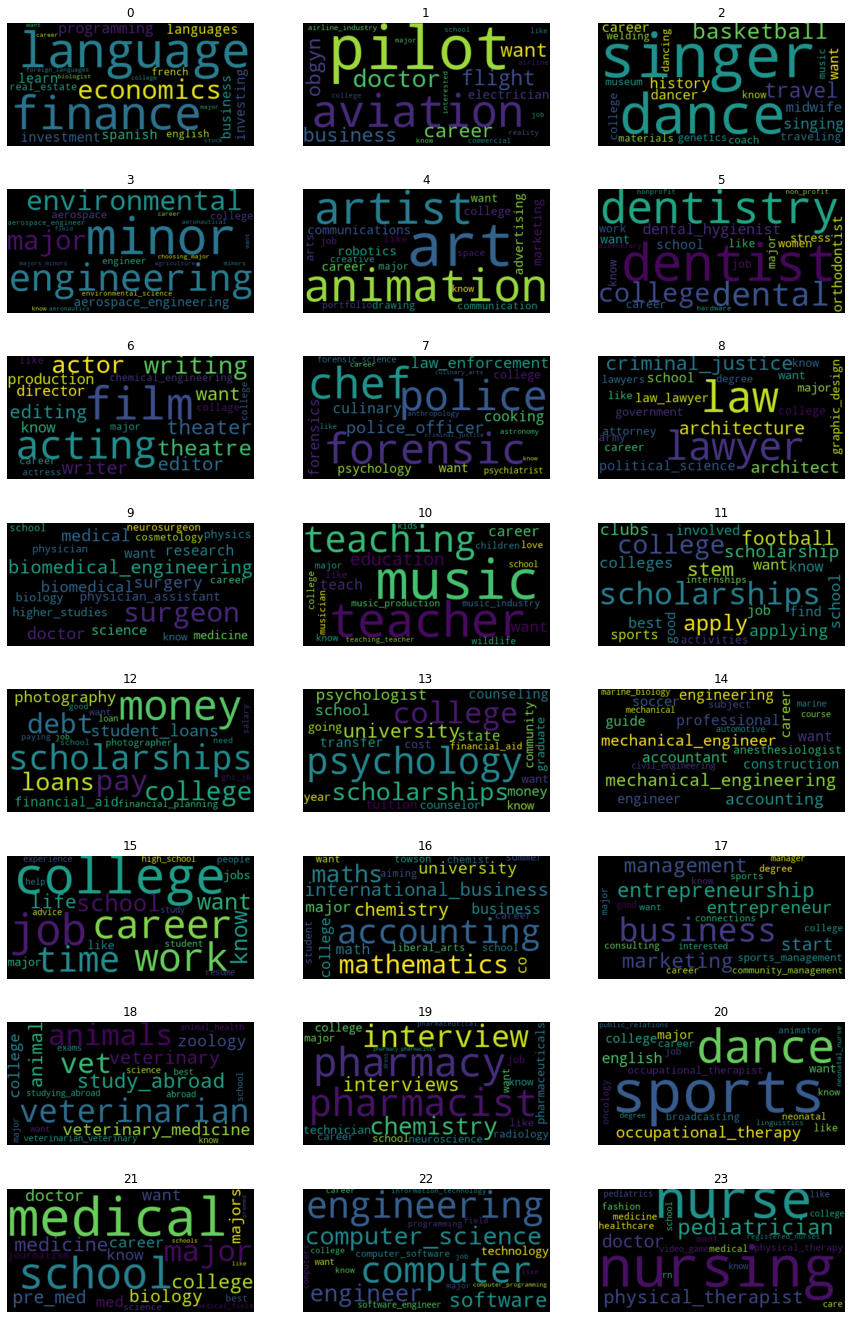

In [19]:
def get_wc(model):

    axis_num = 0
    plt.figure(figsize=(15,24))
    for topic in range(model.state.get_lambda().shape[0]):
        topics_terms = model.state.get_lambda()
        temp_dict = {}
        for i in range(1, len(topics_terms[0])):
            temp_dict[model.id2word[i]]=topics_terms[topic,i]

        wordcloud = WordCloud( margin=0,max_words=20 ).generate_from_frequencies(temp_dict)
        axis_num += 1
        ax = plt.subplot(8, 3, axis_num)

        plt.imshow(wordcloud, interpolation='bilinear')
        title = topic
        plt.title(title)
        plt.axis("off")
        plt.margins(x=0, y=0)
    plt.show()

get_wc(LDAmodel)

### Topics Check-up

For a last check-up in our topics we've ploted 3 questions and the topics that was assigend to them.



The fisrt question was assigend to the topic 10, that's a topic about teaching career.

         how do you become an extraordinary teacher, and not just ordinary? - i want to become a teacher, but i don't want to be average. i want to make a difference in my classroom, and in the field of education.

The second question belong to the 2 topic that's about dancer - singer career.

            how do you start off to become a singer and dancer - i am asking this question because what if im doing stuff but its actually not the right way for me to go to the top.

In [20]:
# give questions their topics

get_topics = list(questions['whole_question_cleaned'].str.split())

test_bow = [id2word.doc2bow(question) for question in get_topics]
tfidf_vectors = tfidf[test_bow]

ids = list(questions['questions_id'])
all_topics = []

for vector in tfidf_vectors:

  topics = []
  topic = LDAmodel.__getitem__(vector, eps= 0.2)

  for tuple_ in topic:
    temp = tuple_[0]
    topics.append(temp)
  all_topics.append(topics)


topics_dict = {'questions_id' : ids, 'topics' : all_topics}
topics = pd.DataFrame(topics_dict)
topics['topics'] = topics['topics'].apply(lambda x: str(x).replace('[', '').replace(']', '').replace(' ', ''))
topics['topic_1'] = topics['topics'].apply(lambda x: x.split(',')[0])
topics['topic_2'] = topics['topics'].apply(lambda x: x.split(',')[1] if len(x) > 2 else float('NaN'))
topics.drop('topics', axis = 1, inplace = True)
questions = questions.merge(topics, on = 'questions_id', how = 'left')

temp = answers[['answers_author_id','questions_id']]
temp.rename(columns = {'answers_author_id' : 'user_id'}, inplace = True)
questions = questions.merge(temp, on = 'questions_id', how = 'right')

temp = professionals[['user_id', 'professionals_industry']]
questions = questions.merge(temp, on = 'user_id', how = 'left')

temp = questions[['whole_question', 'topic_1', 'topic_2']]
display(temp[['whole_question', 'topic_1']].iloc[1234])
display(temp[['whole_question', 'topic_1']].iloc[8254])

whole_question    how do you start off to become a singer and dancer - i am asking this question because what if im doing stuff but its actually not the right way for me to go to the top.  #dancer #model #signer
topic_1           2                                                                                                                                                                                                
Name: 1234, dtype: object

whole_question    what do i need in order to be a mental health counselor? degree? steps? - i am interested in this career because i like socializing with people as well as advising others when needed. additionally i chose to focus on mental health because it has always interested me.  #mental-health #mental-health-counseling
topic_1           15                                                                                                                                                                                                                                                                                                                   
Name: 8254, dtype: object

# RECOMENDATION ENGINE

In this section we'll implement the complete pipeline for our recomendation engine. The pipeline will follow this workflow:

1. Clean the new question : this cleaning will be exactly the same that was did on training data: (lowercase, tokenize, remove stopwords, lemmatize)
2. Infer the vector for the new question : this descriptive vector will allow us to find the most similar questions to our new question in the database.
3. Get the new question topics : that's the final part of our engine, based on its topics the new question will be driven to the professionals who can better answer it.

The professionals will be chosen based on its:
+ Industries;
+ Personal scores for that question (a score based on is other features)
  This personal score will be calculated as follows :
  
  Score = AnswerTimeScore + LocationScore

  AnswerTimeScore = 1/log(MeanResponseTime)
  
  Location = 1 if Student and Professionals are from the same location,
  else 0

In [23]:
questions = questions.drop_duplicates('questions_id').sort_values('questions_date_added', ascending = True).reset_index(drop = True)

topics_industry_frequency = questions.groupby(['topic_1', 'professionals_industry']).sum().reset_index()
topics_industry_uniques = questions.groupby('topic_1')['professionals_industry'].unique().reset_index()

professionals.reset_index(drop = True, inplace = True)

# This pipeline only receives one New Question at Time

def rec_engine_pipeline(new_question : str):

  ''' CLEANING THE NEW QUESTION
  '''

  new_question = new_question.lower() # casting to lower case
  new_question = re.sub(regex , '', new_question) # removing any HTML tags
  cleaned_question = []
  for token in nlp(new_question):
    valid = not token.is_stop and token.is_alpha
    if valid:
      cleaned_question.append(token.lemma_)


  ''' INFER VECTOR WITH DOC2VEC
  '''

  most_similars = model_d2v.docvecs.most_similar([model_d2v.infer_vector(cleaned_question)], topn = 5)
  similar_questions = []
  for i in most_similars:
    similar_question = questions_final['whole_question'].iloc[i[0]]
    similar_questions.append(similar_question)
  x = list(range(5))
  temp = {'top' : x,
            'question' : similar_questions}
  similar_questions = pd.DataFrame(temp)

  ''' GET THE NEW QUESTION TOPICS
  '''

  bow = id2word.doc2bow(cleaned_question)
  tfidf_ = tfidf[bow]

  temp = LDAmodel.__getitem__(vector, eps= 0.2)
  topic_new_question = temp[0][0]

  ''' LOOKING FOR WICH PROFESSIONALS ARE ABLETO ANSWERS TO THE QUESTION TOPIC
  '''

  temp = list(topics_industry_uniques.loc[topics_industry_uniques['topic_1'] == str(topic_new_question)]['professionals_industry'])[0]

  pros_user = []
  for industry in temp:
    industry = str(industry)
    for i, pro_industry in enumerate(list(professionals['professionals_industry'])):
      pro_industry = str(pro_industry)
      if industry in pro_industry:
        temp_dict = {'user_id' : professionals['user_id'].iloc[i],
                      'mean_response_time' : professionals['response_time'].iloc[i],
                      'location' : professionals['professionals_location'].iloc[i]}
        pros_user.append(temp_dict)

  pros_user = pd.DataFrame(pros_user)
  pros_user.drop_duplicates('user_id', inplace = True)
  pros_user['mean_response_time'].fillna(pros_user['mean_response_time'].mean(), inplace = True)
  pros_user['mean_response_time'] = pros_user['mean_response_time'].astype(int)
  pros_user['Score'] = 1/(np.log(pros_user['mean_response_time']))
  pros_user = pros_user[['user_id', 'Score']].sort_values('Score', ascending = False).head(20)

  return similar_questions, topic_new_question, pros_user

### Demonstration

Here is a sample of the Recomendation Engine returns:

+ The 5 most similar questions, that gives our student 3 possiblities:

  1. If he's lucky, his question may already have an answer or the answers for its questions similars may help him in its doubt.
  2. If the answers doesnt help him, he can always get in touch with the professionals who writen those answers to solve his doubt.
  3. In last case, get in touch with the students who asked the similar questions could help him, since they had similar doubts one day.

+ The topic of the new question

+ The professionals who should be able to anwer this new question the faster as possible.


For this demonstration we'll use an arbitrarily chosen question that does not belong to the training data, the question is :

      What kind of technologies should I know to become a data scientist?
      I'm extremely interested in the data science field, and i would like to know how to begin, what should I learn first.

 For this question the location will not be considered.
 This question was assigned to the topic 22, thats the topic for computer science and softwares.

In [24]:
new_question =   "What kind of technologies should I know to become a data scientist? I'm extremely interested in the data science field, and i would like to know how to begin, what should I learn first."
new_question_sims, new_question_topic, pros_able_to_answer = rec_engine_pipeline(new_question)

print('The 5 Most Similar Questions')
display(new_question_sims)
print('\n')
print(f'The new question main topic is the {new_question_topic}.')
print('\n')
display(pros_able_to_answer)

The 5 Most Similar Questions


,top,question
0,0,"what should i learn to be a data scientist? - i want to be a data scientist, what online courses should i take ? #datascience\r\n"
1,1,what do data scientists do? - what kind of companies do data scientists work for? how can i become one?\r\n\r\n #data-science #data-analysis #big-data
2,2,what is the hardest part for working as a forensic scientist? - i want to know what kind of difficulties a typical forensic scientist would have to go through. #forensic
3,3,"what kind of classes would i have to take to be a computer and informational research scientist? - i have always been interested in pursuing a career in the computer science field, and based on my research i feel that i am the most interested in being a computer and informational research scientist. however, i do not know what classes i should take in college to get there. #college #computer-science #computer #research #scientist #classes"
4,4,how long does it take to become a forensic scientist technician? - #forensics #science #forensic




The new question main topic is the 22.




,user_id,Score
478,e47ddebc38cf490c95ead61942815cd7,0.040092
27419,5cbd4a64a328414781df8b75e47ffad3,0.039700
5550,d2e2e6c0e62d4e479ee5143773c00b71,0.039578
58,3516b29f88ec4ea69c46e4cf0adfdb02,0.038859
20977,44f7af4d6f7c4305900a8d2f7eb28167,0.038021
18146,c2d6806bd6e346e584b073dc9a21c30a,0.037831
14653,7af645d883d74288a69955417508c75f,0.037662
5397,0e554cf6fcad45ed9b0110e494fa563a,0.037621
2791,597cd583fb1049deb9b68ce308a992a8,0.037577
2901,a40a0c6070b74fee9492c7b4629a5d59,0.037364


# CONCLUSION AND FURTHER ADVICES 

In order to work with textual data it's extremely important to properly clean and sort the data. This step cannot be ignored since our recomendation engine is a Content Based model, if we give it rubbish input the model will return us rubbish output.

This model is also mainly based on the professionals industries, for better results in future it's extremely recomended to encourage the volounteers to use this data in their profile creation. A system for filling professionals industries based on their other features is also a possibility.

For deploy the models do not need to be trained at every running, a daily training just for add the new data should be enough. The models can be saved and then loaded in any kernel, the recomendation engine can run without the need of training.